In [38]:
from keras.models import load_model
import keraOverlay as overlay
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt 
import utils

In [6]:
#Load preliminary trained model
model = load_model('Scale_down64.h5', custom_objects={'dice_coef_loss': overlay.dice_coef_loss,
                                                      'dice_coef': overlay.dice_coef})

In [7]:
# Load data and masks as dicom files
data_dir = '../../data'                   #Please change the path accordingly before make any changes
normalNames = data_dir + '/GoodData_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

In [11]:
#Load data names that is okay to use and add expand & shrink data
normal_namelist = []
aug_namelist = []
with open(normalNames) as f:
    content = f.readlines()
    normal_namelist = [x.strip() for x in content] 

for name in normal_namelist:
    name_base = name.split('.')[0]
    aug_namelist.append(name)
    aug_namelist.append(name_base+'expand.dcm')
    aug_namelist.append(name_base+'shrink.dcm')
print(aug_namelist)


In [21]:

#Set Cross Validation parameters
#n_data = len(normal_namelist)  #define number of data to be used (use all data if len(normal_namelist)
n_data = 10
k = 5   #Number of folds
n_batch = 4 #Number of batches
data_name_list = normal_namelist[:n_data]
folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(np.array(data_name_list), np.zeros(n_data)))

In [27]:
#Training
from imp import reloads
reload(overlay)
epochs = 2
patience = None  #number of epochs that is tolerated if no improvement
sigma = 1.0   #Gaussian sigma parameter for smooth input image (not mask) before padding/scaling down
n_augment = 1
for index in range(k):
    print(index+1, "/", k, "fold")
    train_list = [data_name_list[i] for i in folds[index][0]]
    val_list = [data_name_list[i] for i in folds[index][1]]
    
    history = model.fit_generator(overlay.generate_batch_data(img_dir, msk_dir, train_list, batch_size=n_batch, 
                                                        scaling=4, smooth=sigma, augument=True, n_aug=n_augment), 
                                  epochs=epochs, verbose=1, steps_per_epoch=len(train_list)/n_batch,
                                  validation_data=overlay.generate_batch_data(img_dir, msk_dir, val_list, batch_size=1, 
                                                        scaling=4, smooth=sigma),
                                  validation_steps=len(val_list),
                                  callbacks=overlay.get_callbacks('Scale_down64.h5', early_stopping_patience=patience))


1 / 5 fold
Epoch 1/2


1/1 [=====================>........] - ETA: 8s - loss: 0.9810 - dice_coef: 0.0190

2/1 [=============================================] - 49s 25s/step - loss: 0.9857 - dice_coef: 0.0143 - val_loss: 0.9849 - val_dice_coef: 0.0151


Epoch 2/2


1/1 [=====================>........] - ETA: 8s - loss: 0.9904 - dice_coef: 0.0096

2/1 [=============================================] - 55s 27s/step - loss: 0.9909 - dice_coef: 0.0091 - val_loss: 0.9846 - val_dice_coef: 0.0154


2 / 5 fold
Epoch 1/2


1/1 [=====================>........] - ETA: 10s - loss: 0.9863 - dice_coef: 0.0137

KeyboardInterrupt: 

In [35]:
#Load data to check first as lists
#from imp import reload
#reload(utils)
x_list, y_list = utils.load_data(img_dir, msk_dir, data_name_list, padding=True, sigma_image=sigma, scaling=4, OPaslist=True)

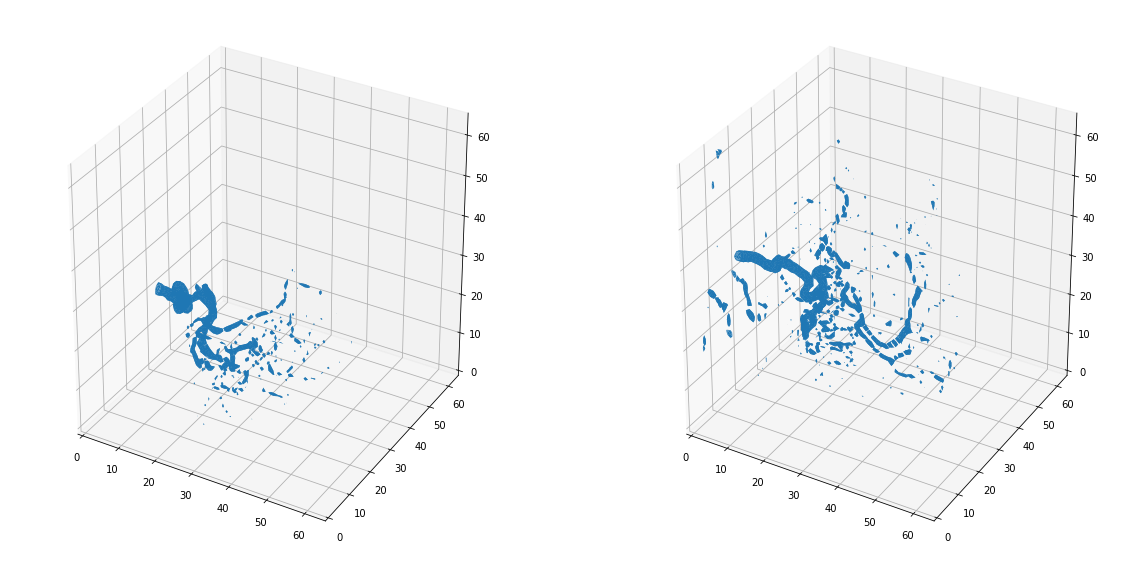

In [39]:
#predict one data and visualize
n_slice = 64
size = 64
print(len(x_list))
index = 9
confidence = 0.9

mask = y_list[index]
prediction = model.predict(x_list[index].reshape(1,n_slice,size,size,1), steps=1)
plt.hist(prediction.flatten())

prediction[prediction>=confidence] = 1
prediction[prediction<confidence] = 0
utils.plot_3d(np.squeeze(prediction), y_list[index], threshold=0.5, threshold2=0.5)

In [41]:

from keras import backend

dice = overlay.dice_coef(mask[np.newaxis,...],prediction[0])

backend.eval(dice)

0.10018347